# Анализ данных приложения с помощью bootstrap  и u-теста

Cуществует таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

## Описание колонок
* value – значения метрики
* experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

## Задача
1. Сравнить результат между тестом и контролем по двум кейсам:
 * Применить бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
 * Применить бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
2. Написать выводы, которые можно сделать на основе анализа примененных критериев

In [1]:
# Импорт нужных библиотек 
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [3]:
data = pd.read_csv('hw_bootstrap.csv',sep=";")

In [4]:
# Предобработка dataframe : убираю лишнюю колонку и привожу данные к нужному формату (float)
data.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [5]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [6]:
data.dtypes

value                object
experimentVariant    object
dtype: object

In [7]:
data["value"] = [float(str(i).replace(",", ".")) for i in data["value"]]
data.head()
data.dtypes

value                float64
experimentVariant     object
dtype: object

In [8]:
# Создаю две группы : контрольную и тестовую
data_control = data.query('experimentVariant == "Control"')
data_test = data.query('experimentVariant == "Treatment"')

(500, 2) 500


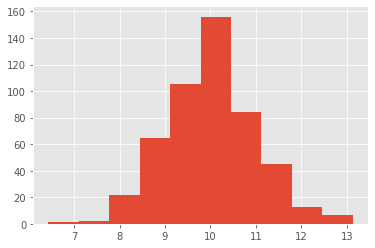

In [9]:
# Рассмотрим распределение и количество значений двух групп подробнее
plt.hist(data_control.value)
print(data_control.shape,data_control.value.nunique())

(500, 2) 500


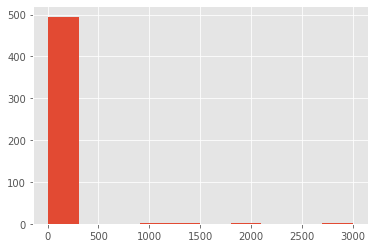

In [10]:
plt.hist(data_test.value)
print(data_test.shape,data_test.value.nunique())

Среднее и медианное значение для контрольной группы:

In [11]:
data_control.mean()

value    10.026867
dtype: float64

In [13]:
data_control.median()

value    10.018465
dtype: float64

Среднее и медианное значение для тестовой группы:

In [12]:
data_test.mean()

value    27.321499
dtype: float64

In [14]:
data_test.median()

value    10.025847
dtype: float64

В данных нет совпадающих значений,в каждой из выборок не менее 3 значений признака и объем групп не различается, следовательно  можно использовать **U-критерий Манна-Уитни** .

In [ ]:
# Проверка гипотезы с помощью U-критерия
stat, p_val = mannwhitneyu(data_control.value, data_test.value)
print('p_val=%.3f' % (p_val))

# Интерпритация результата
alpha = 0.05

if p_val > alpha:
    print('Не можем отклонить H0')
else:
    print('Отклоняем H0')

Рассмотрим **bootstrap метод** для сравнения средних/медиан двух групп, и в заключении сравним полученные значения

In [ ]:
# Объявляю функцию, которая позволит проверять гипотезу о сравнении средних значений с помощью бутстрапа
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [ ]:
# Проверка гипотезы о равенстве средних с помощью бутстрапа
booted_data_1 = get_bootstrap_mean(data_control.value, data_test.value, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [ ]:
p_val_1 = booted_data_1["p_value"]
print('p=%.3f' % (p_val_1))

# Интерпретация результата

if p_val_1 > alpha:
    print('Не можем отклонить H0')
else:
    print('Отклоняем H0')

In [ ]:
# Объявляю функцию, которая позволит проверять гипотезу о сравнении медиан с помощью бутстрапа
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [ ]:
# Проверка гипотезы о равенстве медиан с помощью бутстрапа
booted_data_2 = get_bootstrap_median(data_control.value, data_test.value, boot_it = 2000)

In [ ]:
p_val_2 = booted_data_2["p_value"]
print('p=%.3f' % (p_val_2))

# Интерпретация результата

if p_val_2 > alpha:
    print('Не можем отклонить H0')
else:
    print('Отклоняем H0')

##  Заключение:

* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Сравнение средних значений с помощью bootstrap позволило отклонить нулевую гипотезу о равенстве средних значений двух групп
* Сравнение медиан с помощью bootstrap не позволило отклонить нулевую гипотезу о равенстве медиан двух групп
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы


### Таким образом, хоть U-критерий и позволяет проверить гипотезу о статистически значимых различиях двух групп, но не позволяет сделать однозначный вывод о сравнении средних/медиан двух групп так как неустойчив к дисбалансу. Поэтому при такой постановке задачи лучше использовать метод, который дает более "прямую оценку" параметра распределений - bootstrap метод